## Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU, ReLU, Concatenate, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError, MeanSquaredError, Accuracy
# !pip install tensorflow_io
import tensorflow_io as tfio
from tensorflow.keras.utils import Progbar
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

## Load and Visualize Dataset

In [ ]:
DIRECTORY = '/content/drive/My Drive/Places365'
data = []
max_num_images = 3600
for num, image in enumerate(os.listdir(DIRECTORY)):
    data.append(img_to_array(load_img(DIRECTORY+image)))
    if num + 1 == max_num_images:
      break

NUM_IMAGES = len(data)
print(f'Images Found: {NUM_IMAGES}')
idx = np.random.permutation(NUM_IMAGES)
train_data = data[idx[:3000]]
test_data = data[idx[3000:]]
print(f'Number of training images: {train_data.shape[0]}, Number of testing images: {test_data.shape[0]}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling CaltechData/caltech101/3.0.1.incomplete7G3C7H/caltech101-train.tfrecord*...:   0%|          | 0/3060…

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling CaltechData/caltech101/3.0.1.incomplete7G3C7H/caltech101-test.tfrecord*...:   0%|          | 0/6084 …

Dataset caltech101 downloaded and prepared to CaltechData/caltech101/3.0.1. Subsequent calls will reuse this data.


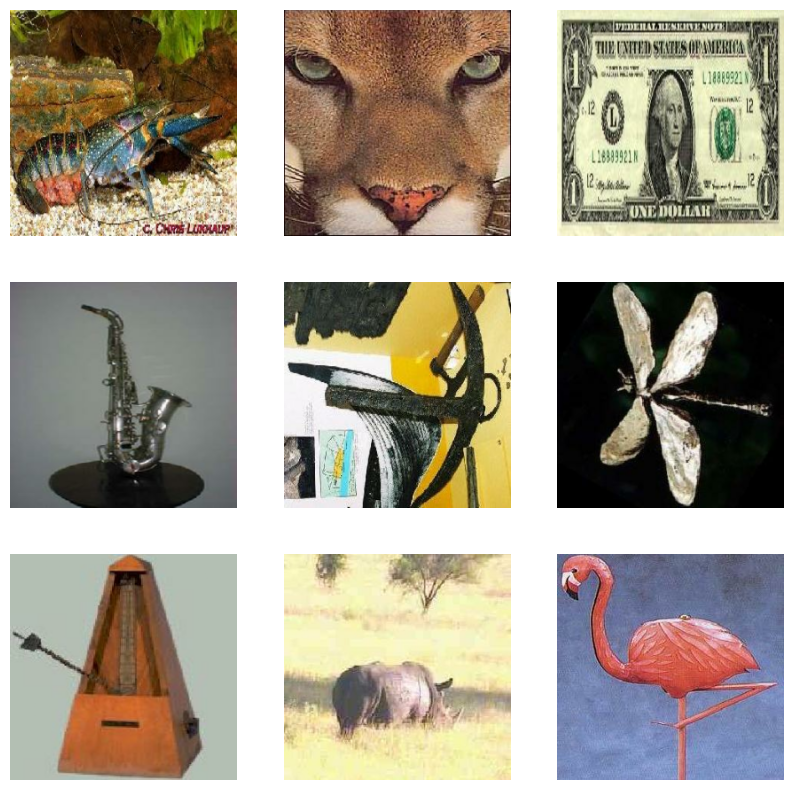

In [ ]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(train_data[:9]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image/255.0)
  plt.axis("off")

## Prepare Dataset for Training

### Image Generator

In [ ]:
image_generator = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True)

### Dataset Generator

In [ ]:
IMG_DIM = (256,256)
BATCH_SIZE = 64
def dataset_generator(data, batch_size=BATCH_SIZE):
    for image_batch in image_generator.flow(data, batch_size=batch_size):
        # resize images
        image_batch = tf.image.resize(image_batch, IMG_DIM)

        # normalize pixel values
        image_batch = tf.cast(image_batch, dtype=tf.float32)
        lab_image = image_batch / 255.0

        # Convert to LAB encoding
        lab_image = tfio.experimental.color.rgb_to_lab(lab_image, illuminant='D65', observer='2') / 128

        # Remove the L dimension for output images
        ab_image = lab_image[:,:,:,1:]

        # Store the L dimension for the input images
        l_image = lab_image[:,:,:,:1]

        yield l_image, ab_image

In [ ]:
for (i,j) in dataset_generator():
  print(i.shape)
  break

(64, 256, 256, 1)


## Build Model

### U-Net Encoding Layer

In [ ]:
class UNetEncLayer(Layer):
  def __init__(self, index, batch_normalize=True, **kwargs):
    super(UNetEncLayer, self).__init__(name=f'UNetEnc_{index}')
    self.conv_layer = Conv2D(**kwargs, name=f'Conv_{index}_Enc')
    self.batch_norm_layer = BatchNormalization(name=f'Batch_Norm_{index}_Enc')
    self.activation = LeakyReLU(alpha=0.2,name=f'Act_{index}_Enc')
    self.batch_normalize = batch_normalize

  def call(self, input):
    x = self.conv_layer(input)
    if self.batch_normalize:
      x = self.batch_norm_layer(x)
    x = self.activation(x)
    return x

### U-Net Decoding Layer

In [ ]:
class UNetDecLayer(Layer):
  def __init__(self, index, batch_normalize=True, **kwargs):
    super(UNetDecLayer, self).__init__(name=f'UNetDec_{index}')
    self.concat_layer = Concatenate(axis=-1)
    self.conv_trans_layer = Conv2DTranspose(**kwargs, name=f'Conv_Trans_{index}_Dec')
    self.batch_norm_layer = BatchNormalization(name=f'Batch_Norm_{index}_Dec')
    self.activation = ReLU(name=f'Act_{index}_Dec')
    self.batch_normalize = batch_normalize

  def call(self, enc_features, dec_input):
    x = self.conv_trans_layer(dec_input)
    x = self.concat_layer([enc_features, x])
    if self.batch_normalize:
      x = self.batch_norm_layer(x)
    x = self.activation(x)
    return x

## Base Model for Generator

### Encoder Architecture

In [ ]:
inp_layer = Input(IMG_DIM+(1,))
enc_1 = UNetEncLayer(1,batch_normalize=False,filters=64,kernel_size=(4,4),padding='same',strides=(1,1),kernel_initializer=GlorotNormal())(inp_layer)

filters_for_enc = [64,128,256,512,512,512,512]
enc_layers = [enc_1]
x = enc_1
for i, filters in enumerate(filters_for_enc):
  x = UNetEncLayer(i+2,filters=filters,kernel_size=(4,4),padding='same',strides=(2,2),kernel_initializer=GlorotNormal())(x)
  enc_layers.append(x)

### Decoder Architecture

In [ ]:
filters_for_dec = [512,512,512,256,128,64,64]
x = enc_layers[-1]
for i, filters in enumerate(filters_for_dec):
  x = UNetDecLayer(i+1,filters=filters,kernel_size=(4,4),padding='same',strides=(2,2),kernel_initializer=GlorotNormal())(enc_layers[-i-2],x)

out_layer = Conv2D(filters=2,kernel_size=(4,4),padding='same',strides=(1,1),kernel_initializer=GlorotNormal(),activation=tf.nn.tanh,name='GenOut')(x)

### Generator Model

In [ ]:
generator = Model(inp_layer, out_layer,name='Generator')
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 UNetEnc_1 (UNetEncLayer)    (None, 256, 256, 64)         1088      ['input_3[0][0]']             
                                                                                                  
 UNetEnc_2 (UNetEncLayer)    (None, 128, 128, 64)         65856     ['UNetEnc_1[0][0]']           
                                                                                                  
 UNetEnc_3 (UNetEncLayer)    (None, 64, 64, 128)          131712    ['UNetEnc_2[0][0]']           
                                                                                          

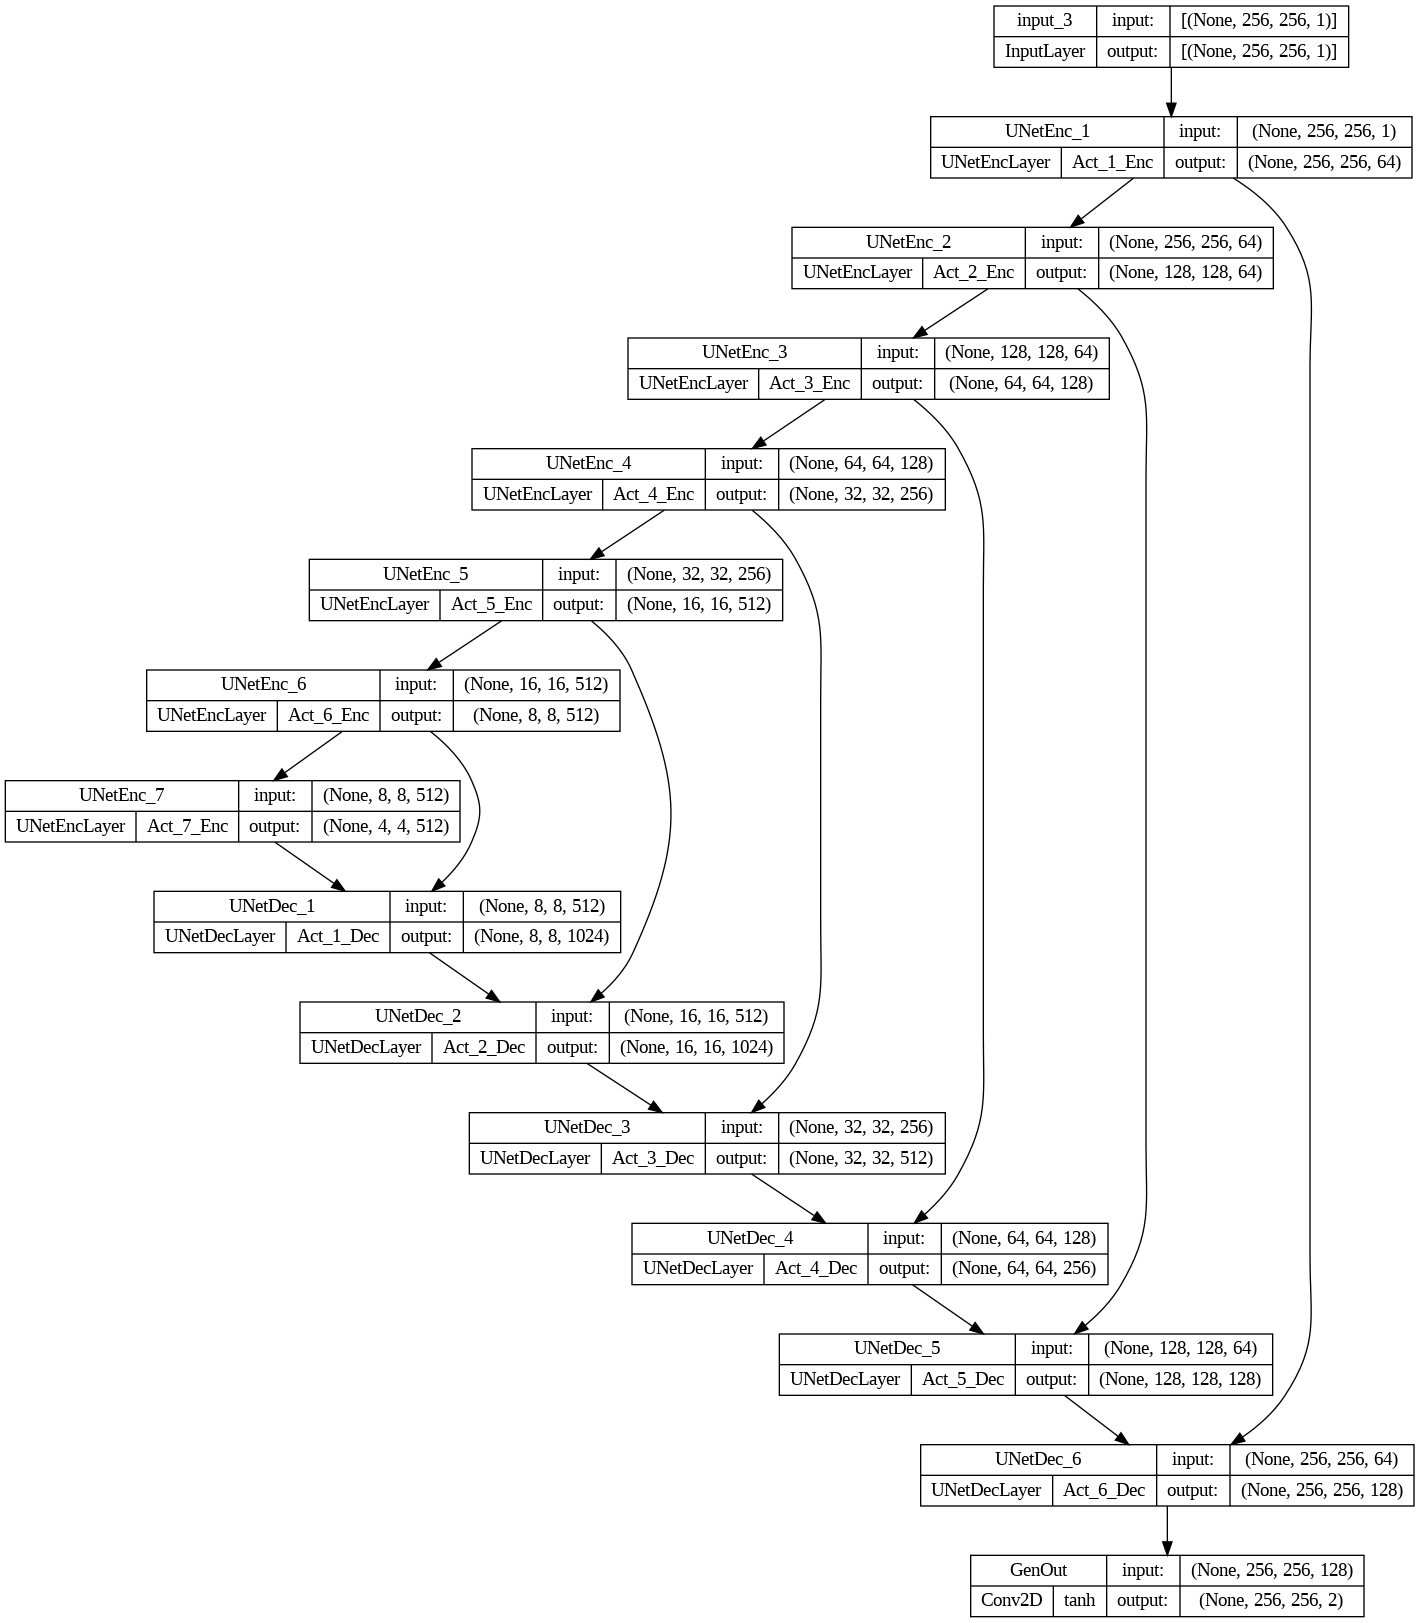

In [ ]:
plot_model(generator,show_shapes=True,show_dtype=False,show_layer_names=True,show_layer_activations=True)

### Discriminator Layer

In [ ]:
class DiscLayer(Layer):
  def __init__(self, index, batch_normalize=True, **kwargs):
    super(DiscLayer, self).__init__(name=f'DiscBlock_{index}')
    self.conv_layer = Conv2D(**kwargs, name=f'Conv_{index}_Disc')
    self.batch_norm_layer = BatchNormalization(name=f'Batch_Norm_{index}_Disc')
    self.activation = LeakyReLU(alpha=0.2,name=f'Act_{index}_Disc')
    self.batch_normalize = batch_normalize

  def call(self, input):
    x = self.conv_layer(input)
    if self.batch_normalize:
      x = self.batch_norm_layer(x)
    x = self.activation(x)
    return x

### Discriminator Model

In [ ]:
disc_inp_layer = Input(IMG_DIM+(3,))
disc_1 = DiscLayer(1,batch_normalize=False,filters=64,kernel_size=(4,4),padding='same',strides=(1,1),kernel_initializer=GlorotNormal())(disc_inp_layer)

filters_for_disc = [64,128,256,512,512,512]
disc_layers = [disc_1]
x = disc_1
for i, filters in enumerate(filters_for_disc):
  x = DiscLayer(i+2,filters=filters,kernel_size=(4,4),padding='same',strides=(2,2),kernel_initializer=GlorotNormal())(x)
  disc_layers.append(x)

disc_out_layer = Conv2D(filters=1, kernel_size=(4,4),padding='same',strides=(1,1),kernel_initializer=GlorotNormal(),activation=tf.nn.sigmoid,name='DiscOut')(x)

In [ ]:
discriminator = Model(disc_inp_layer, disc_out_layer,name='Discriminator')
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 DiscBlock_1 (DiscLayer)     (None, 256, 256, 64)      3136      
                                                                 
 DiscBlock_2 (DiscLayer)     (None, 128, 128, 64)      65856     
                                                                 
 DiscBlock_3 (DiscLayer)     (None, 64, 64, 128)       131712    
                                                                 
 DiscBlock_4 (DiscLayer)     (None, 32, 32, 256)       525568    
                                                                 
 DiscBlock_5 (DiscLayer)     (None, 16, 16, 512)       2099712   
                                                                 
 DiscBlock_6 (DiscLayer)     (None, 8, 8, 512)       

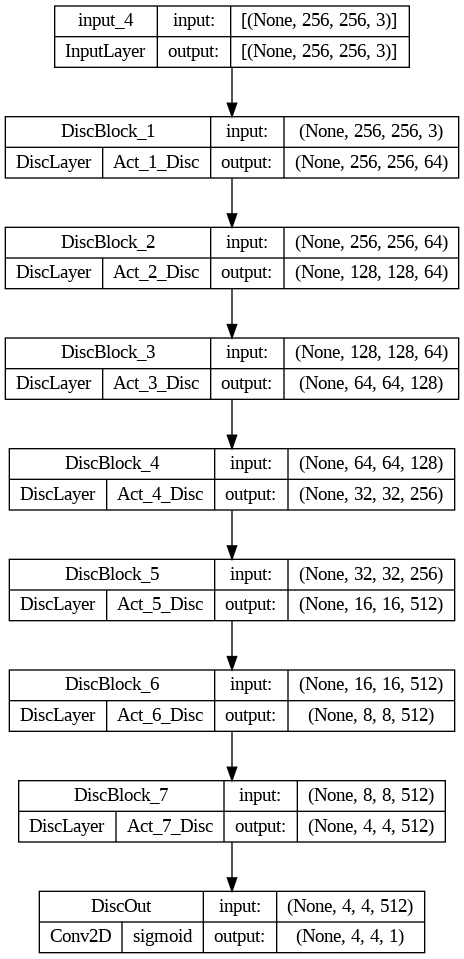

In [ ]:
plot_model(discriminator,show_shapes=True,show_dtype=False,show_layer_names=True,show_layer_activations=True)

## Optimizers

In [ ]:
lr = 2*10e-4
beta_1 = 0.5
gen_opt = Adam(learning_rate=lr, beta_1=beta_1)
disc_opt = Adam(learning_rate=lr, beta_1=beta_1)

## Loss functions

In [ ]:
cross_entropy = BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output) # one sided label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
mae = MeanAbsoluteError()
def generator_loss(fake_output, actual_images, gen_images, lambda_=100):
    gan_loss = -cross_entropy(tf.zeros_like(fake_output), fake_output) # modified loss heuristic
    l1_loss = mae(actual_images, gen_images)
    return gan_loss + lambda_*l1_loss

## Base Model Training

In [ ]:
def psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)
generator.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy','mae','mse',psnr])

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint1_M2.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)
generator.fit(dataset_generator(), epochs=100, steps_per_epoch=30, callbacks=[model_checkpoint_callback])

## GAN Training

### Training Loop

In [ ]:
@tf.function
def train_step(bw_images, ab_images):
    acc = Accuracy()
    mae = MeanAbsoluteError()
    mse = MeanSquaredError()
    psnr = lambda (y_true, y_pred): tf.image.psnr(y_true, y_pred, max_val=1.0)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_images = generator(bw_images, training=True)

      real_output = discriminator(tf.concat([bw_images,ab_images],axis=-1), training=True)
      fake_output = discriminator(tf.concat([bw_images, gen_images], axis=-1), training=True)

      gen_loss = generator_loss(fake_output,ab_images,gen_images)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [('loss',gen_loss+disc_loss),('acc',acc(ab_images, gen_images)),('mae',mae(ab_images, gen_images)), ('mse',mse(ab_images, gen_images)), ('psnr',psnr(ab_images, gen_images))]

In [ ]:
num_steps = int(len(train_data)/BATCH_SIZE)
def train_model(num_epochs):
  for epoch in range(num_epochs):
    prog_bar = Progbar(num_steps, stateful_metrics=['loss','acc','mae','mse','psnr'])
    for i, (bw_images, ab_images) in enumerate(dataset_generator()):
      values = train_step(bw_images, ab_images)
      prog_bar.update(i*BATCH_SIZE, values=values)

## GAN Training

In [ ]:
train_model(300)

## Test Model

In [ ]:
def gen_predictions_and_evaluate(data, metrics):
  predictions = []
  eval_scores = []
  for l_images, ab_images in dataset_generator(data):
    pred_images = generator(l_images)
    predictions.append(pred_images)
    scores = []
    for metric in metrics:
      score = metric(dec_images,pred_images).numpy()
      scores.append(score)
    eval_scores.append(scores)
  eval_scores = tf.reduce_mean(eval_scores, axis=0)
  return tf.concat(predictions,axis=0), eval_scores

In [ ]:
psnr = lambda (y_true, y_pred): tf.image.psnr(y_true, y_pred, max_val=1.0)
predictions, eval_scores = gen_predictions_and_evaluate(test_data, [Accuracy(), MeanAbsoluteError(), MeanSquaredError(), psnr])

In [ ]:
import pandas as pd
test_res = pd.Dataframe(eval_scores,index=['Accuracy','MAE','MSE','PSNR'])
test_res

## Visualize the Output

In [ ]:
idx = np.random.permutation(len(predictions))[:10]
pred_subset = predictions[idx]
actual_subset = test_data[idx]

In [ ]:
_, ax = plt.subplots(n_test, 4, figsize=(25,100))
for i in range(len(pred_subset)):
    img = pred_subset[i]
    l_comp = tfio.experimental.color.rgb_to_lab(actual_subset[i]/255.0, illuminant='D65', observer='2') / 128.0
    l_comp = l_comp[:,:,0]
    full_img = np.zeros((img.shape[0],img.shape[1],3))
    full_img[:,:,0]=l_comp
    full_img[:,:,1:]=img
    full_img = full_img * 128
    lab_a = np.zeros(full_img.shape)
    lab_b = np.zeros(full_img.shape)
    lab_a[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'a'
    lab_b[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'b'
    lab_a[:,:,1] = full_img[:,:,1]
    lab_b[:,:,2] = full_img[:,:,2]
    full_img = tfio.experimental.color.lab_to_rgb(img, illuminant='D65', observer='2')
    lab_a = tfio.experimental.color.lab_to_rgb(lab_a, illuminant='D65', observer='2')
    lab_b = tfio.experimental.color.lab_to_rgb(lab_b, illuminant='D65', observer='2')
    ax[i][0].imshow(tf.cast(full_img[:,:,0], tf.int32))
    ax[i][0].title.set_text('GrayScale Image '+str(i+1))
    ax[i][1].imshow(lab_a)
    ax[i][1].title.set_text('Green-Magenta Channel')
    ax[i][2].imshow(lab_b)
    ax[i][2].title.set_text('Blue-Yellow Channel')
    ax[i][3].imshow(full_img)
    ax[i][3].title.set_text('Predicted Image')
    name = 'DCGAN/Results/predimage'+str(i+1)+'.jpg'
    tf.keras.utils.save_img(name,img)